##Task 1 Domain Generalization (PACS)

In [1]:
class Config:
    seed : int = 42              # the seed for determing results of random
    # data
    data_root: str = "./data"    # where CIFAR10 will download
    batch_size: int = 256        # CIFAR10 is small, so bigger batch ok
    num_workers: int = 2
    num_classes: int = 10        # CIFAR10 = 10 classes

    # training
    epochs: int = 8
    lr: float = 3e-4             # AdamW works fine
    weight_decay: float = 1e-4
    amp: bool = True             # mixed precision

    # image sizes
    img_size: int = 32           # CIFAR10 native resolution
    resnet_in_size: int = 224    # ResNet expects 224x224 (will upscale CIFAR10)
    clip_in_size: int = 224      # CLIP ViT-B/32 expects 224x224

    # models
    resnet_model: str = "resnet50"
    vit_model: str = "vit_small_patch16_224"  # viTS/16 (timm name)
    clip_model: str = "ViT-B/32"

    # training strategy
    freeze_backbone_epochs: int = 2
    # finetune_resnet: bool = True     # train ResNet50
    # use_pretrained_clip: bool = True # CLIP stays frozen

config = Config()


In [2]:
from PIL import Image
import numpy as np      # is ke ialwa ghar nahi chale ga
import matplotlib.pyplot as plt
import cv2
import math    # small math helpers (ceil waghra)
import random           # reproducible shuffling
import copy          # deepcopy models for best chjkpnts
import os
import time
import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim     # optimizers
from torch.utils.data import DataLoader, ConcatDataset     # batched loading
from torchvision import datasets, transforms, models  #datasets + aug
from torchvision.transforms import functional as TF   # low level transforms

SEED = config.seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True   # deterministic convs(slower)
torch.backends.cudnn.benchmark = False      # disable autotuner for determinnsm

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def build_resnet50(num_classes=7):
    # torchvision resnet50 with ImageNet weights
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    in_features = m.fc.in_features  # final feature dim
    m.fc = nn.Linear(in_features, num_classes)  # replace classifier
    return m

def build_vit_s16(num_classes = 7):
    # viT-s/16 pretrained on ImageNet-1k
    m = timm.create_model( config.vit_model, pretrained= True, num_classes =num_classes)
    return m

def count_params(m):
    return sum( p.numel() for p in m.parameters())/1e6

# resnet = build_resnet50().to(device) # make model ?
# vit    = build_vit_s16().to(device)


In [4]:
# Run this command if havent unzipped PACS, make sure to upload the PACS zip to colab
!unzip PACS.zip -d pacs_data

Streaming output truncated to the last 5000 lines.
  inflating: pacs_data/kfold/photo/guitar/063_0045.jpg  
  inflating: pacs_data/kfold/photo/guitar/063_0046.jpg  
  inflating: pacs_data/kfold/photo/guitar/063_0047.jpg  
  inflating: pacs_data/kfold/photo/guitar/063_0048.jpg  
  inflating: pacs_data/kfold/photo/guitar/063_0049.jpg  
  inflating: pacs_data/kfold/photo/guitar/063_0050.jpg  
  inflating: pacs_data/kfold/photo/guitar/063_0051.jpg  
  inflating: pacs_data/kfold/photo/guitar/063_0052.jpg  
  inflating: pacs_data/kfold/photo/guitar/063_0053.jpg  
  inflating: pacs_data/kfold/photo/guitar/063_0054.jpg  
  inflating: pacs_data/kfold/photo/guitar/063_0055.jpg  
  inflating: pacs_data/kfold/photo/guitar/063_0056.jpg  
  inflating: pacs_data/kfold/photo/guitar/063_0059.jpg  
  inflating: pacs_data/kfold/photo/guitar/063_0061.jpg  
  inflating: pacs_data/kfold/photo/guitar/063_0062.jpg  
  inflating: pacs_data/kfold/photo/guitar/063_0065.jpg  
  inflating: pacs_data/kfold/photo/gu

In [5]:
imagenet_mean = [0.485, 0.456, 0.406] # because we are finetuning, not training from scratch
imagenet_std  = [0.229, 0.224, 0.225]

# define transforms
pacs_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# load a specific domain
def get_pacs_domain(root, domain, transform, batch_size=32, shuffle=True):
    domain_path = os.path.join(root, domain)
    dataset = datasets.ImageFolder(domain_path, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataset, loader

root = "/content/pacs_data/kfold"

In [6]:
domains = ["art_painting", "cartoon", "photo", "sketch"]
pacs_classes = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]

loaders = {}

for d in domains:
    _, loaders[d] = get_pacs_domain(root, d, pacs_transform, batch_size=64)

# build new ResNet
resnet_pacs = build_resnet50(len(pacs_classes)).to(device)
vit_pacs = build_vit_s16(len(pacs_classes)).to(device)

print(f"Resnet-50 parameters: {count_params(resnet_pacs):.1f}M")
print(f"ViT-s/16 parameters: { count_params(vit_pacs):.1f}M")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Resnet-50 parameters: 23.5M
ViT-s/16 parameters: 21.7M


In [7]:
# combine datasets/loaders for source domains
source_domains = ["art_painting", "cartoon", "photo"]
source_loaders = [loaders[d] for d in source_domains]
source_datasets = [d.dataset for d in source_loaders]  # extract underlying datasets
combined_dataset = ConcatDataset(source_datasets)
combined_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True)

In [8]:
@torch.no_grad()
def evaluate(model, loader, classnames):
    model.eval()
    total = 0
    correct = 0
    class_correct = [0 for _ in classnames]
    class_total = [0 for _ in classnames]

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        preds = logits.argmax(dim=1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

        # per-class stats
        for l, p in zip(labels, preds):
            class_total[l] += 1
            if l == p:
                class_correct[l] += 1

    overall_acc = correct / total
    per_class_acc = [c/t if t > 0 else 0.0 for c, t in zip(class_correct, class_total)]
    return overall_acc, per_class_acc

In [9]:
def set_backbone_requires_grad(model , requires_grad: bool , head_names = ("fc", "head")):  # full conv
    """freeze ya  tou unfreeze everything except classifier head/heads"""
    for n, p in model.named_parameters():
        #heuristics: allow final 'fc' (resnet) or head (ViT) to train
        if any (n.startswith(h) for h in head_names):
            p.requires_grad = True
        else:
            p.requires_grad = requires_grad

def train_one_epoch(model,loader, optimizer,scaler, epoch, total_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    start = time.time()
    for i, (imgs, labels) in enumerate(loader):
        imgs , labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)

        #amp forward or backward for speed on colab ka gpu
        with torch.cuda.amp.autocast(enabled=config.amp):
            logits = model(imgs)
            loss = F.cross_entropy(logits, labels)

        #keep track of acc
        preds = logits.argmax(dim=1)
        total = total + labels.size(0)
        correct= correct+ (preds == labels).sum(). item( )
        running_loss = running_loss+ loss.item() * labels.size(0)

        #amp backw
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        #light progress each approx 2000 images
        if ( i+1) % max(1 , (2000 // config.batch_size)) == 0:
            bsz_done = (i+1)*config.batch_size  # batch size done
            acc_now = correct / total
            print(f"[epoch {epoch+1}/{total_epochs}] seen={bsz_done:5d} loss={loss.item():.3f} acc~{acc_now:.3f}")

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    dt = time.time() - start
    return epoch_loss, epoch_acc, dt

def fit_classifier(model, name: str, train_loader, test_loader, head_names = ("fc","head")):
    # warmup-- train only the last layers
    set_backbone_requires_grad(model, requires_grad=False, head_names=head_names)
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config.lr, weight_decay=config.weight_decay
    )
    scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

    best_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())

    # tracking history
    train_losses, train_accs, test_accs = [], [], []

    for epoch in range(config.epochs):
        # unfreeze backbone after warmup
        if epoch == config.freeze_backbone_epochs:
            set_backbone_requires_grad(model, requires_grad=True, head_names=head_names)
            optimizer = optim.AdamW(
                model.parameters(), lr=config.lr, weight_decay=config.weight_decay
            )

        loss, train_acc, dt = train_one_epoch(model, train_loader, optimizer, scaler, epoch, config.epochs)
        test_acc, _ = evaluate(model, test_loader, pacs_classes)

        # log history
        train_losses.append(loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"[{name}] epoch {epoch+1}/{config.epochs} | train_loss={loss:.3f} "
              f"train_acc={train_acc:.3f} test_acc={test_acc:.3f} ({dt:.1f}s)")

        # keep best weights
        if test_acc > best_acc:
            best_acc = test_acc
            best_wts = copy.deepcopy(model.state_dict())

    # restore best
    model.load_state_dict(best_wts)
    print(f"[{name}] best test acc: {best_acc:.3f}")

    # plot curves
    epochs_range = range(1, config.epochs + 1)

    plt.figure(figsize=(12,4))

    # training loss
    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_losses, marker='o')
    plt.title(f"{name} Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # accuracy curves
    plt.subplot(1,2,2)
    plt.plot(epochs_range, train_accs, label="Train", marker='o')
    plt.plot(epochs_range, test_accs, label="Test", marker='o')
    plt.title(f"{name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

    return model, best_acc

/tmp/ipython-input-3236808612.py:55: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=config.amp)
/tmp/ipython-input-3236808612.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=config.amp):


[epoch 1/8] seen= 1792 loss=1.847 acc~0.181
[epoch 1/8] seen= 3584 loss=1.727 acc~0.283
[epoch 1/8] seen= 5376 loss=1.640 acc~0.335
[epoch 1/8] seen= 7168 loss=1.517 acc~0.389
[epoch 1/8] seen= 8960 loss=1.391 acc~0.425
[epoch 1/8] seen=10752 loss=1.352 acc~0.469
[epoch 1/8] seen=12544 loss=1.246 acc~0.508
[epoch 1/8] seen=14336 loss=1.226 acc~0.537
[epoch 1/8] seen=16128 loss=1.215 acc~0.563
[epoch 1/8] seen=17920 loss=1.093 acc~0.587
[epoch 1/8] seen=19712 loss=1.112 acc~0.606
[epoch 1/8] seen=21504 loss=1.004 acc~0.620
[epoch 1/8] seen=23296 loss=0.927 acc~0.637
[ResNet50-PACS] epoch 1/8 | train_loss=1.367 train_acc=0.644 test_acc=0.387 (29.0s)
[epoch 2/8] seen= 1792 loss=0.883 acc~0.815
[epoch 2/8] seen= 3584 loss=0.952 acc~0.833
[epoch 2/8] seen= 5376 loss=0.885 acc~0.836
[epoch 2/8] seen= 7168 loss=0.804 acc~0.839
[epoch 2/8] seen= 8960 loss=0.872 acc~0.846
[epoch 2/8] seen=10752 loss=0.793 acc~0.844
[epoch 2/8] seen=12544 loss=0.764 acc~0.849
[epoch 2/8] seen=14336 loss=0.714 ac

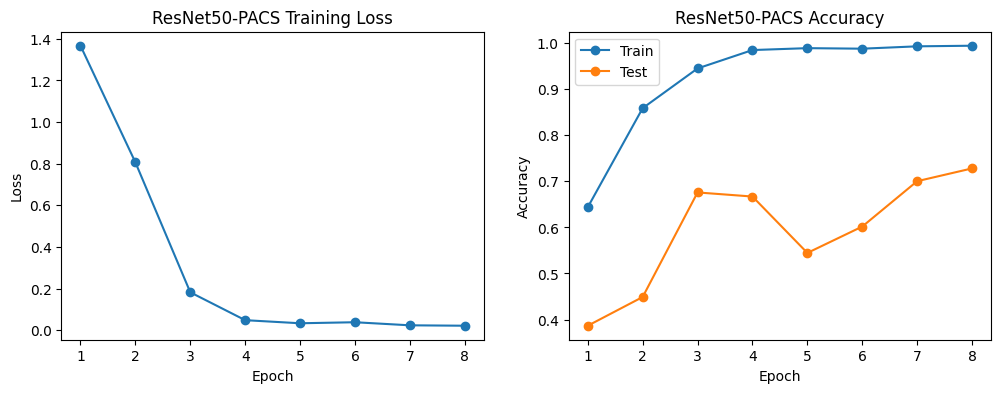

In [10]:
# fine-tune on combined source domains
resnet_pacs, best_acc = fit_classifier(
    resnet_pacs,
    "ResNet50-PACS",
    combined_loader,
    loaders["sketch"],  # test on sketch domain for simplicity
    head_names=("fc", "head")
)

/tmp/ipython-input-3236808612.py:55: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=config.amp)
/tmp/ipython-input-3236808612.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=config.amp):


[epoch 1/8] seen= 1792 loss=1.910 acc~0.190
[epoch 1/8] seen= 3584 loss=1.733 acc~0.232
[epoch 1/8] seen= 5376 loss=1.347 acc~0.283
[epoch 1/8] seen= 7168 loss=1.323 acc~0.345
[epoch 1/8] seen= 8960 loss=0.899 acc~0.406
[epoch 1/8] seen=10752 loss=0.944 acc~0.458
[epoch 1/8] seen=12544 loss=0.860 acc~0.500
[epoch 1/8] seen=14336 loss=0.729 acc~0.533
[epoch 1/8] seen=16128 loss=0.570 acc~0.559
[epoch 1/8] seen=17920 loss=0.662 acc~0.583
[epoch 1/8] seen=19712 loss=0.652 acc~0.602
[epoch 1/8] seen=21504 loss=0.600 acc~0.623
[epoch 1/8] seen=23296 loss=0.630 acc~0.638
[ViT-PACS] epoch 1/8 | train_loss=1.076 train_acc=0.647 test_acc=0.090 (24.8s)
[epoch 2/8] seen= 1792 loss=0.500 acc~0.846
[epoch 2/8] seen= 3584 loss=0.589 acc~0.837
[epoch 2/8] seen= 5376 loss=0.426 acc~0.848
[epoch 2/8] seen= 7168 loss=0.556 acc~0.848
[epoch 2/8] seen= 8960 loss=0.473 acc~0.853
[epoch 2/8] seen=10752 loss=0.362 acc~0.858
[epoch 2/8] seen=12544 loss=0.565 acc~0.860
[epoch 2/8] seen=14336 loss=0.410 acc~0.8

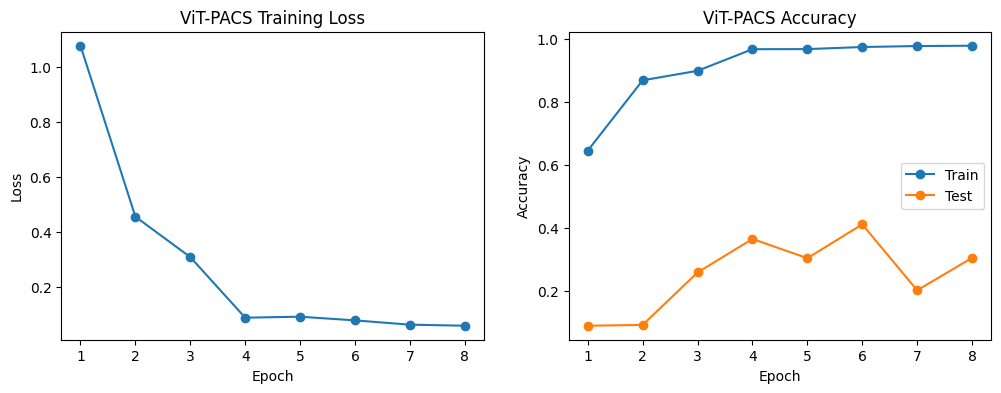

In [11]:
vit_pacs, best_acc = fit_classifier(
    vit_pacs,
    "ViT-PACS",
    combined_loader,
    loaders["sketch"],  # test on sketch domain for simplicity
    head_names=("fc", "head")
)

In [12]:
resnet_acc, resnet_per_class = evaluate(
    resnet_pacs,
    loaders["sketch"],
    pacs_classes
)

vit_acc, vit_per_class = evaluate(
    vit_pacs,
    loaders["sketch"],
    pacs_classes
)

# print overall accuracies
print(f"ResNet50-PACS overall accuracy on Sketch: {resnet_acc:.3f}")
print(f"ViT-PACS overall accuracy on Sketch: {vit_acc:.3f}")

# per-class accuracies
for c, r_acc, cl_acc in zip(pacs_classes, resnet_per_class, vit_per_class):
    print(f"{c:10s} | ResNet: {r_acc:.3f} | ViT: {cl_acc:.3f}")

ResNet50-PACS overall accuracy on Sketch: 0.728
ViT-PACS overall accuracy on Sketch: 0.412
dog        | ResNet: 0.416 | ViT: 0.216
elephant   | ResNet: 0.696 | ViT: 0.970
giraffe    | ResNet: 0.652 | ViT: 0.408
guitar     | ResNet: 0.993 | ViT: 0.211
horse      | ResNet: 0.893 | ViT: 0.248
house      | ResNet: 0.912 | ViT: 0.338
person     | ResNet: 0.800 | ViT: 0.444


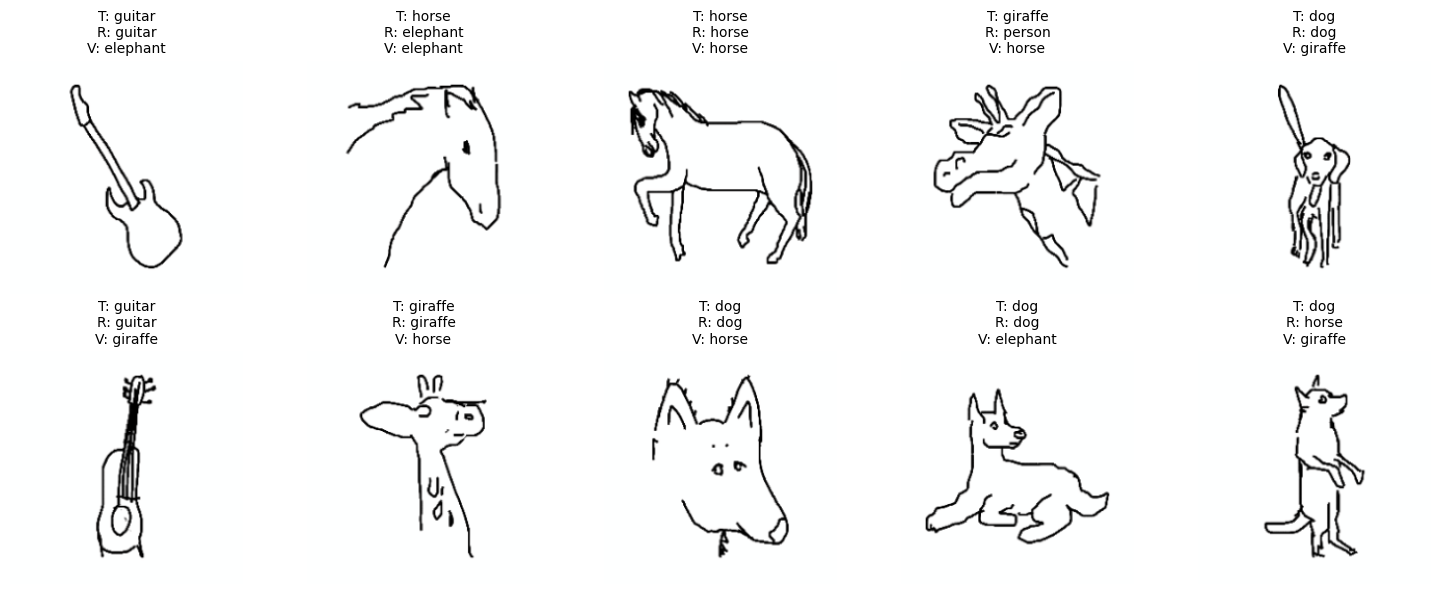

In [14]:
# pick 10 random indices
dataset = loaders["sketch"].dataset
indices = random.sample(range(len(dataset)), 10)

plt.figure(figsize=(15,6))

for i, idx in enumerate(indices):
    img, label = dataset[idx]   # already ResNet/ViT-normalized tensor

    # ResNet prediction
    resnet_pacs.eval()
    with torch.no_grad():
        inp = img.unsqueeze(0).to(device)
        logits = resnet_pacs(inp)
        resnet_pred = logits.argmax(dim=1).item()

    # ViT prediction
    vit_pacs.eval()
    with torch.no_grad():
        inp = img.unsqueeze(0).to(device)
        logits = vit_pacs(inp)
        vit_pred = logits.argmax(dim=1).item()

    # show original image (undo ImageNet normalization for display)
    img_show = img.permute(1,2,0).cpu().numpy()
    img_show = img_show * imagenet_std + imagenet_mean  # undo normalization
    img_show = img_show.clip(0,1)

    plt.subplot(2,5,i+1)
    plt.imshow(img_show)
    plt.axis("off")
    plt.title(f"T: {pacs_classes[label]}\nR: {pacs_classes[resnet_pred]}\nV: {pacs_classes[vit_pred]}",
              fontsize=10)

plt.tight_layout()
plt.show()
